In [1]:
%tensorflow_version 1.x
import os
import warnings
warnings.filterwarnings("ignore")

TensorFlow 1.x selected.


In [2]:
!pip install Pillow numpy opencv-python PyWavelets tqdm slugify -q
!pip install -U Flask -q
!pip install lws==1.2.6 -q
!pip install tflearn -q
!pip install librosa==0.7.2 -q
!pip install numba==0.48 -q
!pip install mock -q 
!pip install pydub -q
!pip install noisereduce -q
from pydub import AudioSegment
import tensorflow as tf
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython
import IPython.display as ipd
import soundfile as sf
import pandas as pd
import numpy as np
import random
from scipy.constants import speed_of_light as speedlight
from unittest.mock import Mock, MagicMock
import noisereduce as nr
from scipy.io import wavfile


# Collect amino acid vibrational frequencies as wavenumbers
!wget https://raw.githubusercontent.com/frodoCombs/Amino_Acid_Frequencies/master/aa_freq.csv -q
#Ual
!git clone https://github.com/ual-cci/music_gen_interaction_RTML.git -q



     |████████████████████████████████| 153kB 7.8MB/s 
     |████████████████████████████████| 1.6MB 7.3MB/s 
     |████████████████████████████████| 3.6MB 8.5MB/s 
     |████████████████████████████████| 20.2MB 1.5MB/s 
ERROR: umap-learn 0.5.1 has requirement numba>=0.49, but you'll have numba 0.48.0 which is incompatible.
ERROR: pynndescent 0.5.2 has requirement numba>=0.51.2, but you'll have numba 0.48.0 which is incompatible.


In [3]:
# Dictionary to be used for converting amino acid abbreviations
aa_3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S',
'GLN': 'Q', 'LYS':'K','ILE': 'I', 'PRO': 'P',
 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 'GLY': 'G',
 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


df = pd.read_csv('/content/aa_freq.csv', sep=',',header=0)


df.fillna(0,inplace=True)


#convert to np array
df = df.values
for ro in range(df.shape[0]):
    for co in range(df.shape[1]):
        if co == 0:
        #Convert amino acid code from 3 letter to 1 letter
            aa = df[ro][co]
            aa = aa[0:3].upper()
            df[ro][co]= aa_3to1[aa]
        else:
        # Convert from wavenumber to frequency
        # wavelength = 1/wavenumber
        # frequency = speed of light / wavelength
            if df[ro][co] > 0:
                freq = speedlight / (1/df[ro][co])


aa_list = df[:,0]      # list of amino acids
df = df[:,1:]          # remove first column                
max_freq = df.max()    # max and min 
min_freq = df.min()    # need to exclude first column
human_range = 20000 - 20
for ro in range(df.shape[0]):
    for co in range(df.shape[1]):
        if df[ro][co] > 0:
            # First scale to 0 to 1
            df[ro][co] = (df[ro][co] - min_freq)/ max_freq - min_freq
            # Scale to human hearing range 20 - 20000 Hz
            df[ro][co] = (df[ro][co] * human_range) + 20

def aa_note(aa,length):
    row = np.where(aa_list == aa)[0][0]
    wave = np.zeros(int(44100 * float(length)))
    harm = 0
 
    for freq in df[row]:
        if freq == 0:
            break
        else:
            volume = np.exp(-harm)
            phases = np.cumsum(2.0 * np.pi * freq / 44100 * np.ones(int(44100 * float(length))))
            wave += np.sin(phases) * volume
            harm += 1
    # scale wave to values between 1 and -1
    wave = 2.*(wave - wave.min())/np.ptp(wave)-1
    return wave




In [4]:
# a sample protein sequence
#https://www.bioinformatics.org/sms2/random_protein.html
protein_sequence = 'VKMSHPSGDVEAILACYEGCCPGSVYGNVVAFLYAALINGERWFVTNTSMSLESYNTVKMSHPSGDVEAILACYEGCCPGSVYGNVVAFLYAALINGERWFVTNTSMSLESYNVKMSHPSGDVEAILACYEGCCPGSVYGNVVAFLYAALINGERWFVTNTSMSLESYN'

unit_length = 0.5
melodic_sequence = []
for residue in protein_sequence:
    sound_wave = aa_note(residue,unit_length)
    melodic_sequence = melodic_sequence + sound_wave.tolist()
melody = np.asarray(melodic_sequence)
melody = 2*(melody - melody.min())/np.ptp(melody)-1



In [5]:
sr=22050
def show_audio(y, sr=220500, xlim=5000):
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_xlim(0,xlim)
    ax.set_ylim(-1,1)
    ax.plot(y)
    return ipd.Audio(y, rate=sr,  autoplay=True)
    
sf.write('long_sample.wav', melody, sr)

In [6]:
librosa.get_duration(melody, sr)



169.0

In [7]:
%cd /content/music_gen_interaction_RTML/

args = MagicMock(name='method')
sample_rate = 22050

# This will set the same setting for the training and the running of the model:
args.lstm_layers = 3
args.lstm_units = 128
args.sample_rate = sample_rate
args.sequence_length = 40
args.async_loading = True
args.amount_epochs = -1

/content/music_gen_interaction_RTML


In [8]:
# Time to miliseconds
startTime = 1*1000
endTime = 61*1000

# Opening file and extracting segment
song = AudioSegment.from_wav( '/content/long_sample.wav' )
extract = song[startTime:endTime]

# Saving
extract.export( '/content/music_gen_interaction_RTML/sample.wav', format="wav")

<_io.BufferedRandom name='/content/music_gen_interaction_RTML/sample.wav'>

In [9]:
number_of_epochs = 300 # will take cca 8min

song_name = "sample.wav" # < we will train the model on this wav file
model_name = "my_trained_model" # < and then save the model under this name (check the .tfl files in the folder afterwards)

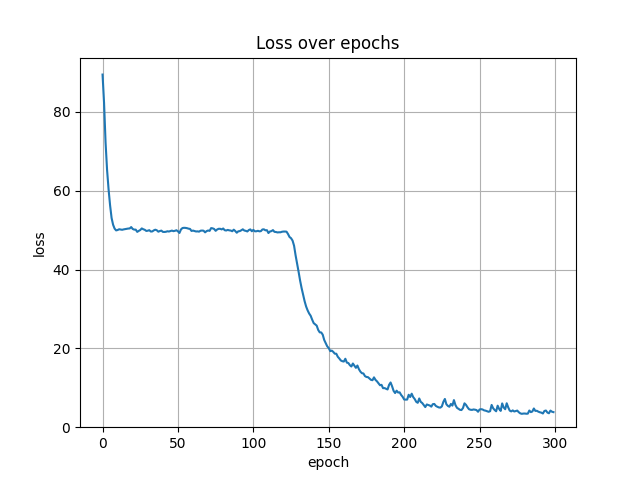

In [10]:
# ----[keep the same bellow]-------------------------------------------------------------------

# takes time!
!python training_handler.py -target_file $song_name -model_name $model_name -amount_epochs $number_of_epochs -batch_size 512 \
                            -lstm_layers $args.lstm_layers  -lstm_units $args.lstm_units -sample_rate $args.sample_rate -sequence_length $args.sequence_length
from IPython.display import clear_output 
clear_output()

import glob
import numpy as np
i = glob.glob("*.tfl.png")
from IPython.display import Audio, Image
display(Image(i[0]))




In [11]:
# Here you can change the paths to other trained models / other song files
load_generative_seeds_from = song_name
load_model_from = model_name+".tfl"

In [12]:
from server_handler import ServerHandler
import settings

my_settings = settings.Settings(args)
print("Important Settings: settings.lstm_layers=", my_settings.lstm_layers, ", settings.lstm_units=", my_settings.lstm_units,
              ", settings.sample_rate=", my_settings.sample_rate)

generation_handler = ServerHandler(my_settings, manual_loading = True)
generation_handler.manual_init_song_model(load_generative_seeds_from, load_model_from)

# slightly experimental interpolation through the latents while generating ...

generation_handler.change_impulse(0.2) # set to 20% sharp

sequence = [
  #Starts generating 10% through the song and generates 200 frames 
  [0.1, 200],
  #Moves to 60% through the song and generates 300 frames
  [0.6, 300],
  #Moves to 90% through the song and generates 150 frames
  [0.9, 150]            
]

output_audio = []

for i in sequence:
  position_in_the_song = i[0]
  requested_length = i[1]
  generation_handler.change_impulse_smoothly_start(position_in_the_song) # allow interpolation
  audio, predict, reconstruct = generation_handler.generate_audio_sample(requested_length, interactive_i=position_in_the_song)
  output_audio.append(audio)

clear_output()

In [13]:
import librosa
from IPython.display import Audio, Image
output_audio = np.concatenate(output_audio)

out_name = 'generated_output_exp_concat.wav'
librosa.output.write_wav(out_name, output_audio, sr=sample_rate)
Audio(out_name)

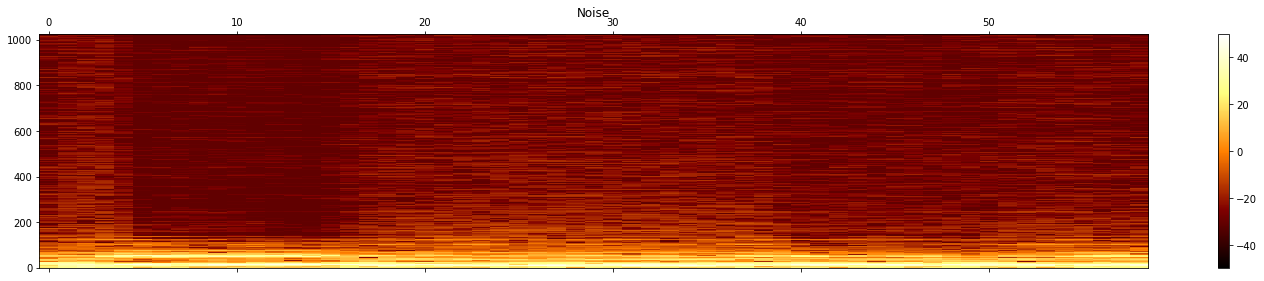

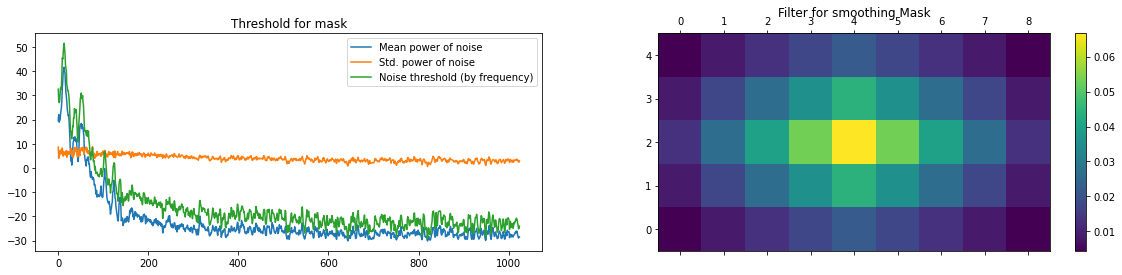

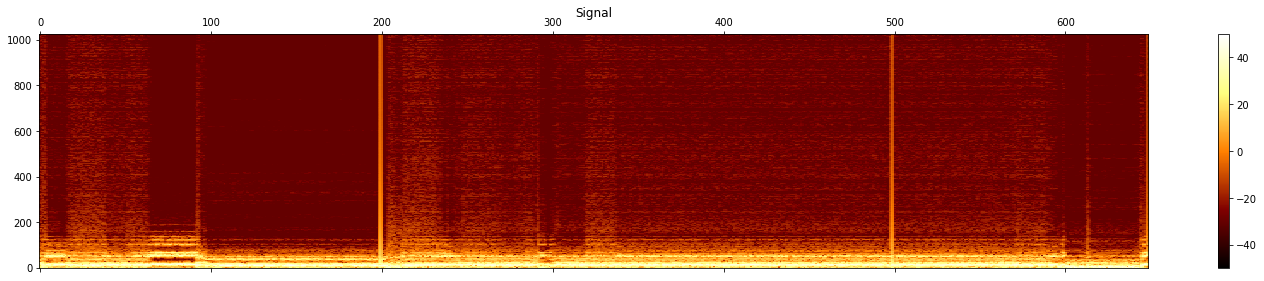

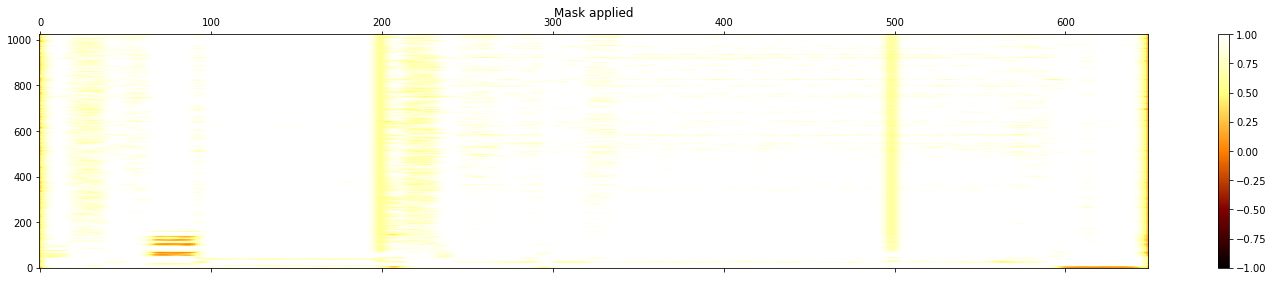

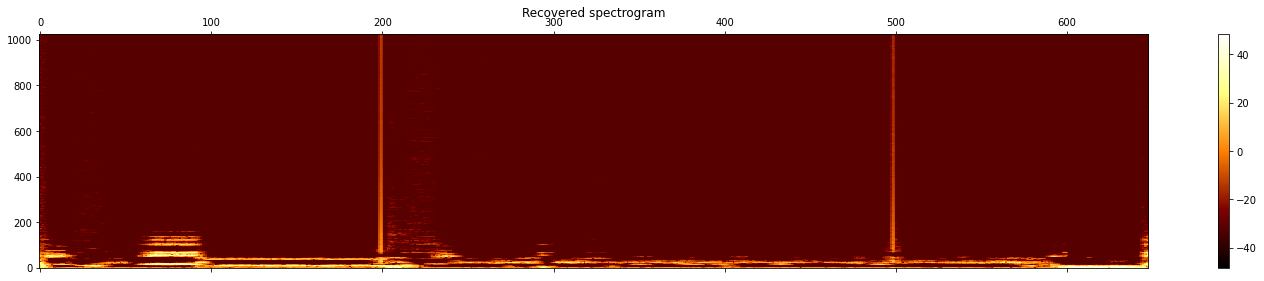

In [14]:

# load data
rate, data = wavfile.read("/content/music_gen_interaction_RTML/generated_output_exp_concat.wav")
# select section of data that is noise
noisy_part = data[0:30000]
# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=True)
'''noise_reduced = nr.reduce_noise(audio_clip=data.astype('float32'),
                                noise_clip=noisy_part.astype('float32'),
                                use_tensorflow=True, 
                                verbose=False)'''
IPython.display.Audio(data=data, rate=rate)

In [ ]:
# fast cleanup
'''!mkdir unused
!mv *.wav unused/
!mv *.m4a unused/'''